<a href="https://colab.research.google.com/github/jamescastano-a/Automatiza-con-Max/blob/main/curva_ROC_y_AUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LA CURVA ROC (*RECEIVER OPERATING CHARACTERISTIC*) Y EL *AUC* (*AREA UNDER THE ROC CURVE*)

## Contenido

1. [Introducción](#scrollTo=TPhR-plWlM2T&line=5&uniqifier=1)
2. [Motivación](#scrollTo=u-SypeyRdjVk&line=1&uniqifier=1)
3. [Definiciones](#scrollTo=D1yFRwBsgvUV&line=1&uniqifier=1)
4. [Variación de TPR y FPR con el umbral seleccionado](#scrollTo=M52ymzxOXm2c&line=1&uniqifier=1)
5. [La curva ROC](#scrollTo=HF-yvyHRavlU&line=7&uniqifier=1)
6. [El AUC](#scrollTo=DUkGdpJPiL85&line=5&uniqifier=1)
7. [Conclusión]()

##1. Introducción

En videos anteriores hemos hablado de herramientas para medir el desempeño de clasificadores, como la exactitud, la matriz de confusión, el *precision*, el *recall* y el *F1-score*.

En este video veremos otra de esas herramientas que nos permite evaluar el desempeño de un clasificador de forma gráfica.

##2. Motivación

En algunos clasificadores se requiere la elección de un **umbral** y este umbral puede afectar las tasas de aciertos y desaciertos:

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


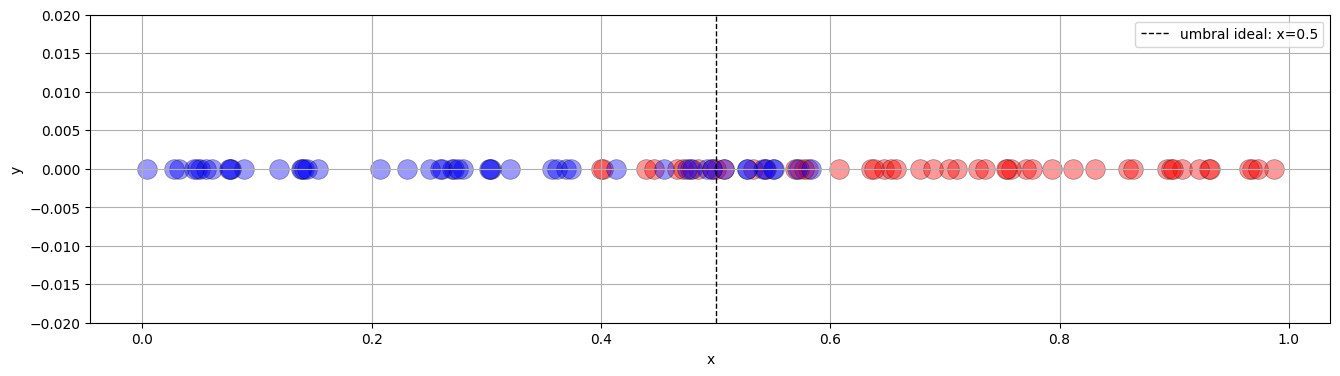

In [ ]:
# Importar librerías
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/gdrive')

# Leer dataset
datos = pd.read_csv('/gdrive/MyDrive/02-CODIFICANDOBITS.COM/05-YouTube/02-Videos/2023-03-31-ROC_AUC/code_datos/dataset_rojos_azules.csv')
rojos = datos['coordenada'][datos['categoría']==1].values
azules = datos['coordenada'][datos['categoría']==0].values

# Y graficarlo
fig, ax = plt.subplots(figsize=(16,4))
plt.scatter(rojos,np.zeros(rojos.shape),color='red',s=200, alpha=0.4, edgecolors="k", linewidths=0.5)
plt.scatter(azules,np.zeros(azules.shape),color='blue',s=200, alpha=0.4, edgecolors="k", linewidths=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-0.02,0.02)
plt.axvline(0.5,color='k',linestyle='--',linewidth=1, label='umbral ideal: x=0.5')
plt.legend()
plt.grid();

Por ejemplo:

- Si movemos el umbral a la izquierda (<0.5) detectaremos más puntos rojos pero menos puntos azules
- Si movemos el umbral a la derecha (>0.5) detectaremos más puntos azules pero menos puntos rojos

¿Cuál sería el valor más adecuado para el umbral?

##3. Definiciones

###3.1. Positivos y negativos

La definición de lo que es "positivo" y "negativo" depende del contexto. Ejemplo:

- En un sistema de diagnóstico "positivo" podría ser la detección de la enfermedad y "negativo" la ausencia de la enfermedad.
- En un sistema de detección de fraudes "positivo" podría ser la presencia de fraude y "negativo" la ausencia

En nuestro ejemplo hipotético supondremos:
- "positivo" $→$ "punto rojo"
- "negativo" $→$ "punto azul"

El objetivo será separar "positivos" de "negativos" de la mejor manera posible

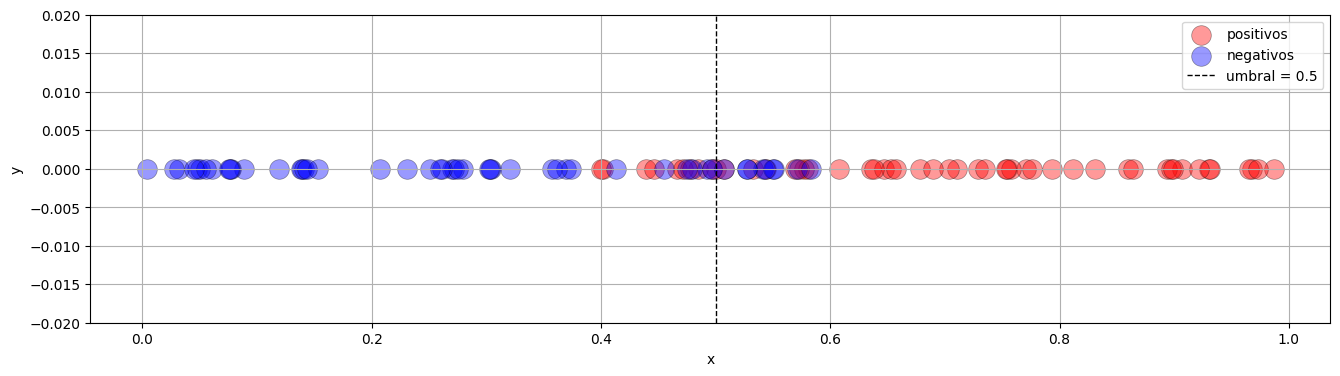

In [ ]:
# Función para graficar el dataset y el umbral
def graficar_dataset(data, threshold):
    # Puntos rojos y puntos azules
    rojos = data['coordenada'][data['categoría']==1].values
    azules = data['coordenada'][data['categoría']==0].values

    # Gráfica
    fig, ax = plt.subplots(figsize=(16,4))
    plt.scatter(rojos,np.zeros(rojos.shape),color='red',s=200, alpha=0.4, edgecolors="k", linewidths=0.5, label='positivos')
    plt.scatter(azules,np.zeros(azules.shape),color='blue',s=200, alpha=0.4, edgecolors="k", linewidths=0.5, label='negativos')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-0.02,0.02)
    plt.axvline(threshold,color='k',linestyle='--',linewidth=1, label=f'umbral = {threshold}')
    plt.legend()
    plt.grid();

graficar_dataset(datos, 0.5)

###3.2. TP, FP, TN, FN

- *Verdaderos positivos (TP)*: "rojos" clasificados como "rojos"
- *Falsos positivos (FP)*: "azules" clasificados como "rojos"
- *Verdaderos negativos (TN)*: "azules" clasificados como "azules"
- *Falsos negativos (FN)*: "rojos" clasificados como "azules"

###3.3. Tasa de verdaderos positivos (TPR) y tasa de falsos positivos (FPR)

**Tasa de verdaderos positivos** (*TPR: true positive rate*):
- Definición: de todo lo que es realmente POSITIVO ¿qué proporción fue clasificada como POSITIVO?
- Nombre alternativo: **tasa de verdaderos positivos** (*TPR: true positive rate*)
- Cálculo: $Recall = TPR = \frac{TP}{TP+FN}$
- Rango de valores: 0 a 1 (ó 0% a 100%)

**Tasa de falsos positivos** (*FPR: false positive rate*):
- Definición: ¿de todo lo que realmente era NEGATIVO que fue clasificado incorrectamente como POSITIVO?
- Cálculo: $FPR = \frac{FP}{FP+TN}$
- Rango de valores: 0 a 1 (ó 0% a 100%)

In [ ]:
# Funciones para calcular TP, TN, FP, FN, FPR y TPR

# TP: positivos (1s) clasificados como positivos (1s)
def calcular_TP(y_true,y_pred):
    multip = y_true*y_pred
    return np.sum(multip) # Sólo los positivos (1s) en ambos arreglos se sumarán

# TN: negativos (0s) clasificados como negativos (0s)
def calcular_TN(y_true,y_pred):
    # Multiplicar los arreglos invertidos(1->0, 0->1) pues en este caso nos
    # interesan los 0s
    multip = (1-y_true)*(1-y_pred)
    return np.sum(multip) # Sólo los negativos (0s) en ambos arreglos se sumarán

# FN: positivos (1s) clasificados como negativos (0s)
def calcular_FN(y_true,y_pred):
    # Los FN son simplemente todos los positivos - TP
    positivos = np.sum(y_true)      # Todos los positivos
    tp = calcular_TP(y_true,y_pred) # Verdaderos positivos
    return positivos - tp           # Falsos negativos

# FP: negativos (0s) clasificados como positivos (1s)
def calcular_FP(y_true,y_pred):
    # Los FP son simplemente todos los negativos - TN
    negativos = np.sum(1-y_true)    # Todos los negativos
    tn = calcular_TN(y_true,y_pred) # Verdaderos negativos
    return negativos - tn           # Falsos positivos

# FPR = FP/(FP+TN)
def calcular_FPR(y_true,y_pred):
    fp = calcular_FP(y_true,y_pred)
    tn = calcular_TN(y_true,y_pred)
    return fp/(fp+tn)

# TPR = TP/(TP+FN)
def calcular_TPR(y_true,y_pred):
    tp = calcular_TP(y_true,y_pred)
    fn = calcular_FN(y_true,y_pred)
    return tp/(tp+fn)

In [ ]:
# Ejemplo de prueba
y_true = np.array([1,1,1,0,0,0]) # positivos = 3, negativos = 3
y_pred = np.array([0,1,1,0,1,0]) # TP=2, TN=2, FN=1, FP=1

print(f'TP: {calcular_TP(y_true,y_pred)}')
print(f'TN: {calcular_TN(y_true,y_pred)}')
print(f'FN: {calcular_FN(y_true,y_pred)}')
print(f'FP: {calcular_FP(y_true,y_pred)}')
print(f'TPR: {100*calcular_TPR(y_true,y_pred):.1f}% (Porcentaje de positivos clasificados como positivos)')
print(f'FPR: {100*calcular_FPR(y_true,y_pred):.1f}% (Porcentaje de negativos clasificados como positivos)')

TP: 2
TN: 2
FN: 1
FP: 1
TPR: 66.7% (Porcentaje de positivos clasificados como positivos)
FPR: 33.3% (Porcentaje de negativos clasificados como positivos)


##4. Variación de TPR y FPR con el umbral seleccionado

Al cambiar el umbral de nuestro clasificador, cambiarán las TPR y FPR:

Umbral: 0.5
TPR: 82.0%
FPR: 18.0%


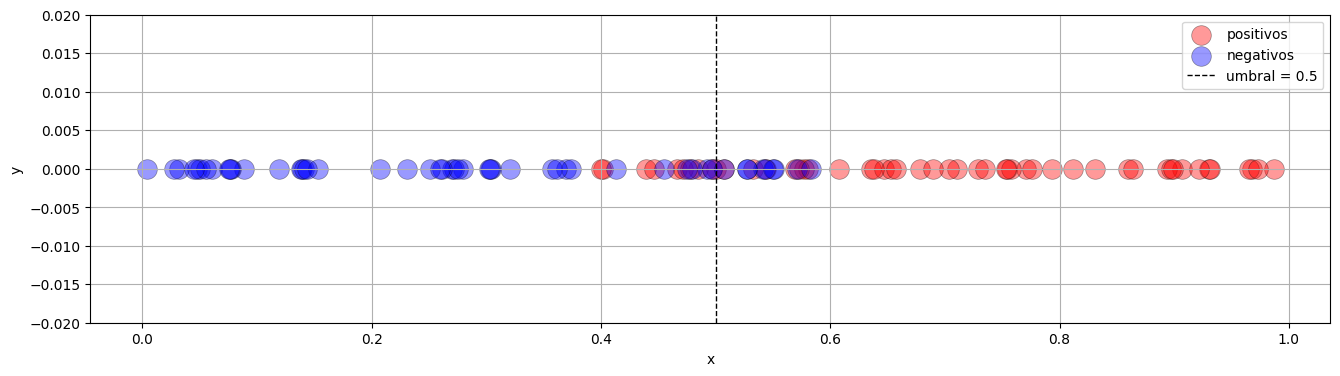

In [ ]:
# Categorías reales
y_true = datos['categoría'].values # Categorías reales: 1->rojo, 0->azul

# Caso 1: umbral=0.5
umbral = 0.5

# Predicción
coords = datos['coordenada'].values
y_pred = np.zeros(y_true.shape)
y_pred[coords>=umbral] = 1 # Si la coordenada >= umbral -> punto rojo

# Calcular TPR y FPR
print(f'Umbral: {umbral}')
print(f'TPR: {100*calcular_TPR(y_true,y_pred):.1f}%')
print(f'FPR: {100*calcular_FPR(y_true,y_pred):.1f}%')

# Y graficar
graficar_dataset(datos,umbral)

Umbral: 0.6
TPR: 66.0%
FPR: 0.0%


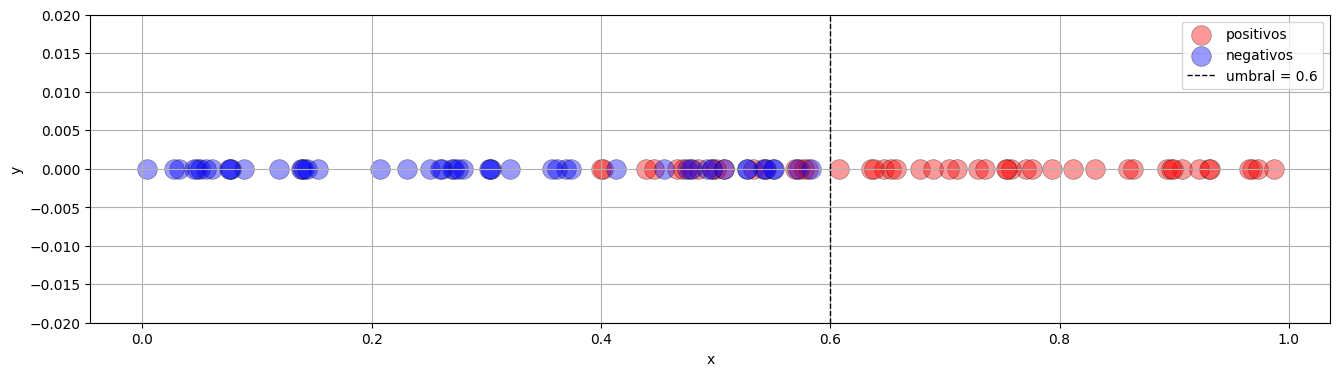

In [ ]:
# Caso 2: umbral=0.6
umbral = 0.6

# Predicción
y_pred = np.zeros(y_true.shape)
y_pred[coords>=umbral] = 1 # Si la coordenada >= umbral -> punto rojo

# Calcular TPR y FPR
print(f'Umbral: {umbral}')
print(f'TPR: {100*calcular_TPR(y_true,y_pred):.1f}%')
print(f'FPR: {100*calcular_FPR(y_true,y_pred):.1f}%')

# Y graficar
graficar_dataset(datos,umbral)

Umbral: 0.35
TPR: 100.0%
FPR: 38.0%


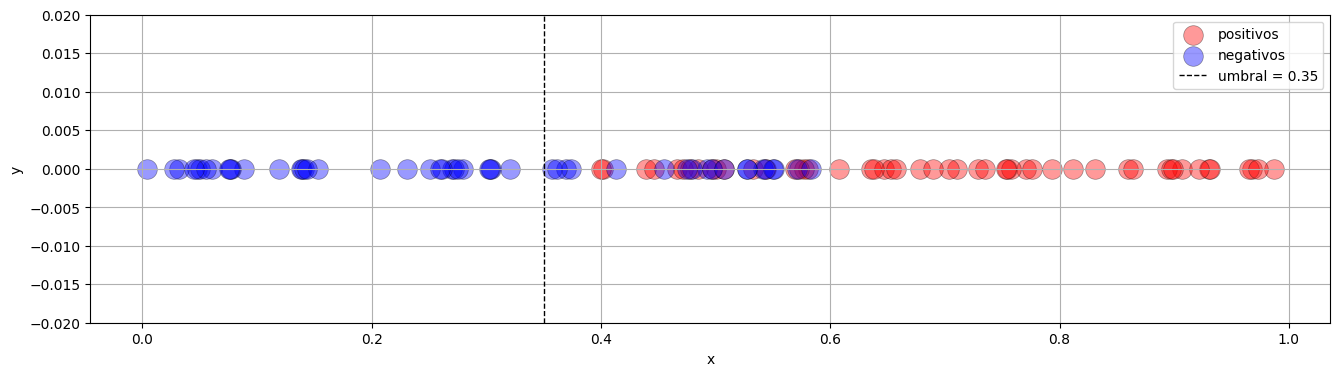

In [ ]:
# Caso 3: umbral=0.35
umbral = 0.35
y_true = datos['categoría'].values # Categorías reales: 1->rojo, 0->azul

# Predicción
y_pred = np.zeros(y_true.shape)
y_pred[coords>=umbral] = 1 # Si la coordenada >= umbral -> punto rojo

# Calcular TPR y FPR
print(f'Umbral: {umbral}')
print(f'TPR: {100*calcular_TPR(y_true,y_pred):.1f}%')
print(f'FPR: {100*calcular_FPR(y_true,y_pred):.1f}%')

# Y graficar
graficar_dataset(datos,umbral)

El cambio de umbral usualmente implica un aumento/disminución de las TPR y FPR

La idea es ver cómo se comportan estos TPR y FPR con el umbral para decidir si nuestro clasificador tiene o no un buen desempeño.

Para ello debemos construir una curva de TPR vs. FPR.

##5. La curva ROC (*Receiver Operating Characteristic*)

Es una gráfica que muestra la variación de TPR (eje vertical) vs. FPR (eje horizontal) a medida que cambia el umbral de nuestro clasificador.

Permite determinar de forma gráfica qué tan bien o mal lo hace el clasificador en términos de las tasas de verdaderos y falsos positivos:

![](https://drive.google.com/uc?export=view&id=1oXdqPEVecrzJFYK3glKDfRU9REs2BfC6)

Posibles situaciones:
1. Clasificador ideal: tendrá una TPR=1 y una FPR=0
2. Clasificador aleatorio: ¡es como lanzar una moneda! Existirá la misma probabilidad de acertar o fallar, por tanto TPR=FPR
3. Un "buen" clasificador deberá tener una curva ROC **cercana** al punto ideal
4. Un "mal" clasificador tendrá una curva ROC **alejada** del punto ideal

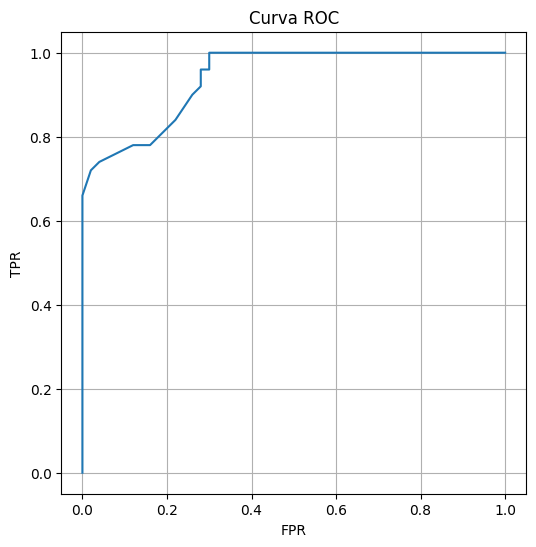

In [ ]:
# Obtengamos la AUC del clasificador
def curva_ROC(data, plot_auc=False):
    # Definir rango de umbrales
    umbrales = np.linspace(0,1,50)

    # Definir y_true
    y_true = data['categoría'].values # Categorías reales: 1->rojo, 0->azul

    # Para cada umbral calcular TPR y FPR a partir de la predicción
    # y almacenar los resultados
    tprs = []
    fprs = []
    coords = data['coordenada'].values
    for umbral in umbrales:
        # Predicciones
        y_pred = np.zeros(y_true.shape)
        y_pred[coords>=umbral] = 1 # Si la coordenada >= umbral -> punto rojo

        # Calcular TPR y FPR para el umbral
        tpr = calcular_TPR(y_true,y_pred)
        fpr = calcular_FPR(y_true,y_pred)

        # Añadir a los listados
        tprs.append(tpr)
        fprs.append(fpr)

    # Y construir la gráfica
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(fprs,tprs)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    # Y dibujar AUC si plot_auc=True
    if plot_auc:
        plt.fill_between(fprs,tprs,alpha=0.4)
        title = 'Curva ROC y AUC'
    else:
        title = 'Curva ROC'
    plt.title(title)
    plt.grid();

    return tprs, fprs

TPRS, FPRS = curva_ROC(datos)

##6. AUC: área bajo la curva ROC (*Area Under the ROC Curve*)

Es una manera equivalente de determinar qué tan bien o mal lo hace el clasificador.

El AUC es simplemente un valor numérico que indica el área bajo la curva ROC:

![](https://drive.google.com/uc?export=view&id=1uzTNS-onmtwl73xDGSx6MVffw10N-7T-)

Posibles situaciones:
1. Clasificador ideal: AUC = 1
2. Clasificador aleatorio: AUC = 0.5
3. Un "buen" clasificador deberá tener una AUC cercana a 1
4. Un "mal" clasificador tendrá una AUC menor que 0.5

In [ ]:
# Calculemos el AUC de nuestro clasificador
from sklearn.metrics import auc

print(f'AUC del clasificador: {auc(FPRS,TPRS)}')

AUC del clasificador: 0.9412


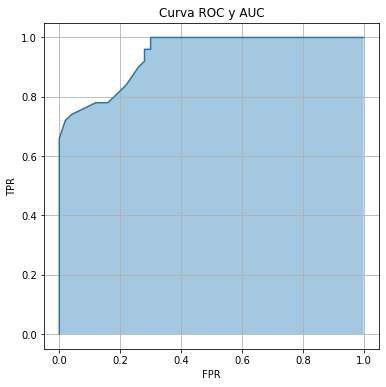

In [ ]:
TPRS, FPRS = curva_ROC(datos,plot_auc=True)

## 7. Selección del mejor umbral con base en la ROC

In [ ]:
# Definir rango de umbrales
umbrales = np.linspace(0.2,0.8,20)

# Iterar por los umbrales y en cada caso calcular y almacenar FPR y TPR
tprs = []
fprs = []
coords = datos['coordenada'].values
y_true = datos['categoría'].values # Categorías reales: 1->rojo, 0->azul
for umbral in umbrales:
    # Predicciones
    y_pred = np.zeros(y_true.shape)
    y_pred[coords>=umbral] = 1 # Si la coordenada >= umbral -> punto rojo

    # Calcular TPR y FPR para el umbral
    tpr = calcular_TPR(y_true,y_pred)
    fpr = calcular_FPR(y_true,y_pred)

    # Añadir a los listados
    tprs.append(tpr)
    fprs.append(fpr)

# Calcular distancias
tprs = np.array(tprs)
fprs = np.array(fprs)
distancias = np.sqrt(np.array(1.-tprs)**2 + np.array(fprs)**2)

# Buscar la posición para la menor distancia obtenida
idx = np.argmin(distancias)

# Y extraer el mejor umbral correspondiente
mejor_umbral = umbrales[idx]
print(f'Mejor umbral basado en la ROC: {mejor_umbral}')

Mejor umbral basado en la ROC: 0.48421052631578954


In [ ]:
# Con este mejor umbral calcular por ejemplo el F1-score
from sklearn.metrics import f1_score

y_pred = np.zeros(y_true.shape)
y_pred[coords>=mejor_umbral] = 1 # Si la coordenada >= umbral -> punto rojo

print(f'F1-score: {f1_score(y_true,y_pred)}')

F1-score: 0.8269230769230769


##7. Conclusiones

- El ROC y el AUC son otras dos herramientas que permiten medir el desempeño de un clasificador **cuando requerimos definir un umbral** (el cual puede afectar las TPR y FPR)
- Si tenemos varios clasificadores podemos comparar sus ROCs y AUCs y elegir aquel que tenga un comportamiento más cercano al ideal.

Machine learnig clase sesión 6


In [8]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# configuraciòn de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print("Librerias importadas correctamente")
#de vegetación: bosque denso, pastizal, cultivo, vegetación escasa, suelo

#definimos 5 tipos de vegetación con caracteristicas distintas
tipo_vegetacion={
    'Bosque Denso' :{
        'NDVI' :(0.4, 0.6),
        'EVI' :(0.6 , 0.8),
        'Banda_roja' : (0.05, 0.15),
        'Banda_nir' : (0.2, 0.7),
        'banda_verde' :(0.1, 0.2),
        'Humedad' :(0.6, 0.8)
    },
    'Pastizal' :{
        'NDVI' :(0.4, 0.6),
        'EVI' :(0.3 , 0.55),
        'Banda_roja' : (0.2, 0.35),
        'Banda_nir' : (0.3, 0.8),
         'banda_verde' :(0.1, 0.2),
         'Humedad' :(0.3, 0.5)
    },
    'cultivo' :{
        'NDVI' :(0.2, 0.4),
        'EVI' :(0.4, 0.6),
        'Banda_roja' : (0.2, 0.35),
        'Banda_nir' : (0.4, 0.6),
        'banda_verde' :(0.12, 0.25),
        'Humedad' :(0.5, 0.7)},
    'Vegetacion_escasa' :{
        'NDVI' :(0.2, 0.4),
        'EVI' :(0.15, 0.35),
        'Banda_roja' : (0.3, 0.45),
        'Banda_nir' : (0.4, 0.6),
        'banda_verde' :(0.12, 0.25),
        'Humedad' :(0.5, 0.7)},
    'Suelo_desnudo' :{
        'NDVI' :(-0.1, 0.15),
        'EVI' :(-0.05, 0.1),
        'Banda_roja' : (0.4, 0.6),
        'Banda_nir' : (0.15, 0.35),
        'banda_verde' :(0.25, 0.4),
        'Humedad' :(0.2, 0.4)}
}

n_samples = 500 # nùmero de pixeles / puntos observados

datos_lista= []
etiquetas_reales = []
for tipo, caracteristicas in tipo_vegetacion.items():
  n = n_samples // 5 #Distribución de Datos
  for _ in range(n):
    punto = {
        'NDVI' : np.random.uniform(*caracteristicas['NDVI']),
        'EVI' : np.random.uniform(*caracteristicas['EVI']),
        'Banda_roja' : np.random.uniform(*caracteristicas['Banda_roja']),
        'Banda_nir' : np.random.uniform(*caracteristicas['Banda_nir']),
        'banda_verde' : np.random.uniform(*caracteristicas['banda_verde']),
        'Humedad' : np.random.uniform(*caracteristicas['Humedad'])
}
    datos_lista.append(punto)
    etiquetas_reales.append(tipo)
#Crear Dataframe
df= pd.DataFrame(datos_lista)
df['Tipo_Real'] = etiquetas_reales

print(f"Datos generados: {len(df)} observaciones satelitales")
print(f"\n primeros filas del dataset: ")
print(df.head(10))

Librerias importadas correctamente
Datos generados: 500 observaciones satelitales

 primeros filas del dataset: 
       NDVI       EVI  Banda_roja  ...  banda_verde   Humedad     Tipo_Real
0  0.581619  0.763896    0.127274  ...     0.152649  0.654307  Bosque Denso
1  0.547987  0.721927    0.105978  ...     0.167393  0.659787  Bosque Denso
2  0.428842  0.743873    0.120584  ...     0.121907  0.754065  Bosque Denso
3  0.587802  0.635619    0.056576  ...     0.195795  0.613150  Bosque Denso
4  0.579413  0.656883    0.136855  ...     0.198736  0.648296  Bosque Denso
5  0.426779  0.692973    0.056779  ...     0.194606  0.652519  Bosque Denso
6  0.438000  0.646383    0.141374  ...     0.140771  0.641284  Bosque Denso
7  0.450898  0.631806    0.097742  ...     0.182527  0.659660  Bosque Denso
8  0.539687  0.618443    0.104260  ...     0.105122  0.651246  Bosque Denso
9  0.595174  0.723306    0.065316  ...     0.184511  0.765791  Bosque Denso

[10 rows x 7 columns]


In [9]:
print("estadistica descriptiva : ")
print(df.describe())
print(f"\ Distribución de tipos de vegetación:")
print(df['Tipo_Real'].value_counts())

estadistica descriptiva : 
             NDVI         EVI  Banda_roja   Banda_nir  banda_verde     Humedad
count  500.000000  500.000000  500.000000  500.000000   500.000000  500.000000
mean     0.325137    0.380328    0.303485    0.448455     0.198882    0.519657
std      0.183093    0.235079    0.140568    0.145650     0.073411    0.156723
min     -0.096546   -0.049927    0.050531    0.152086     0.100305    0.202880
25%      0.218948    0.206782    0.219508    0.336279     0.146559    0.369528
50%      0.350644    0.413156    0.304961    0.458721     0.180207    0.550909
75%      0.465222    0.551581    0.404446    0.552619     0.230918    0.650928
max      0.595802    0.796585    0.599496    0.787254     0.395321    0.796801
\ Distribución de tipos de vegetación:
Tipo_Real
Bosque Denso         100
Pastizal             100
cultivo              100
Vegetacion_escasa    100
Suelo_desnudo        100
Name: count, dtype: int64


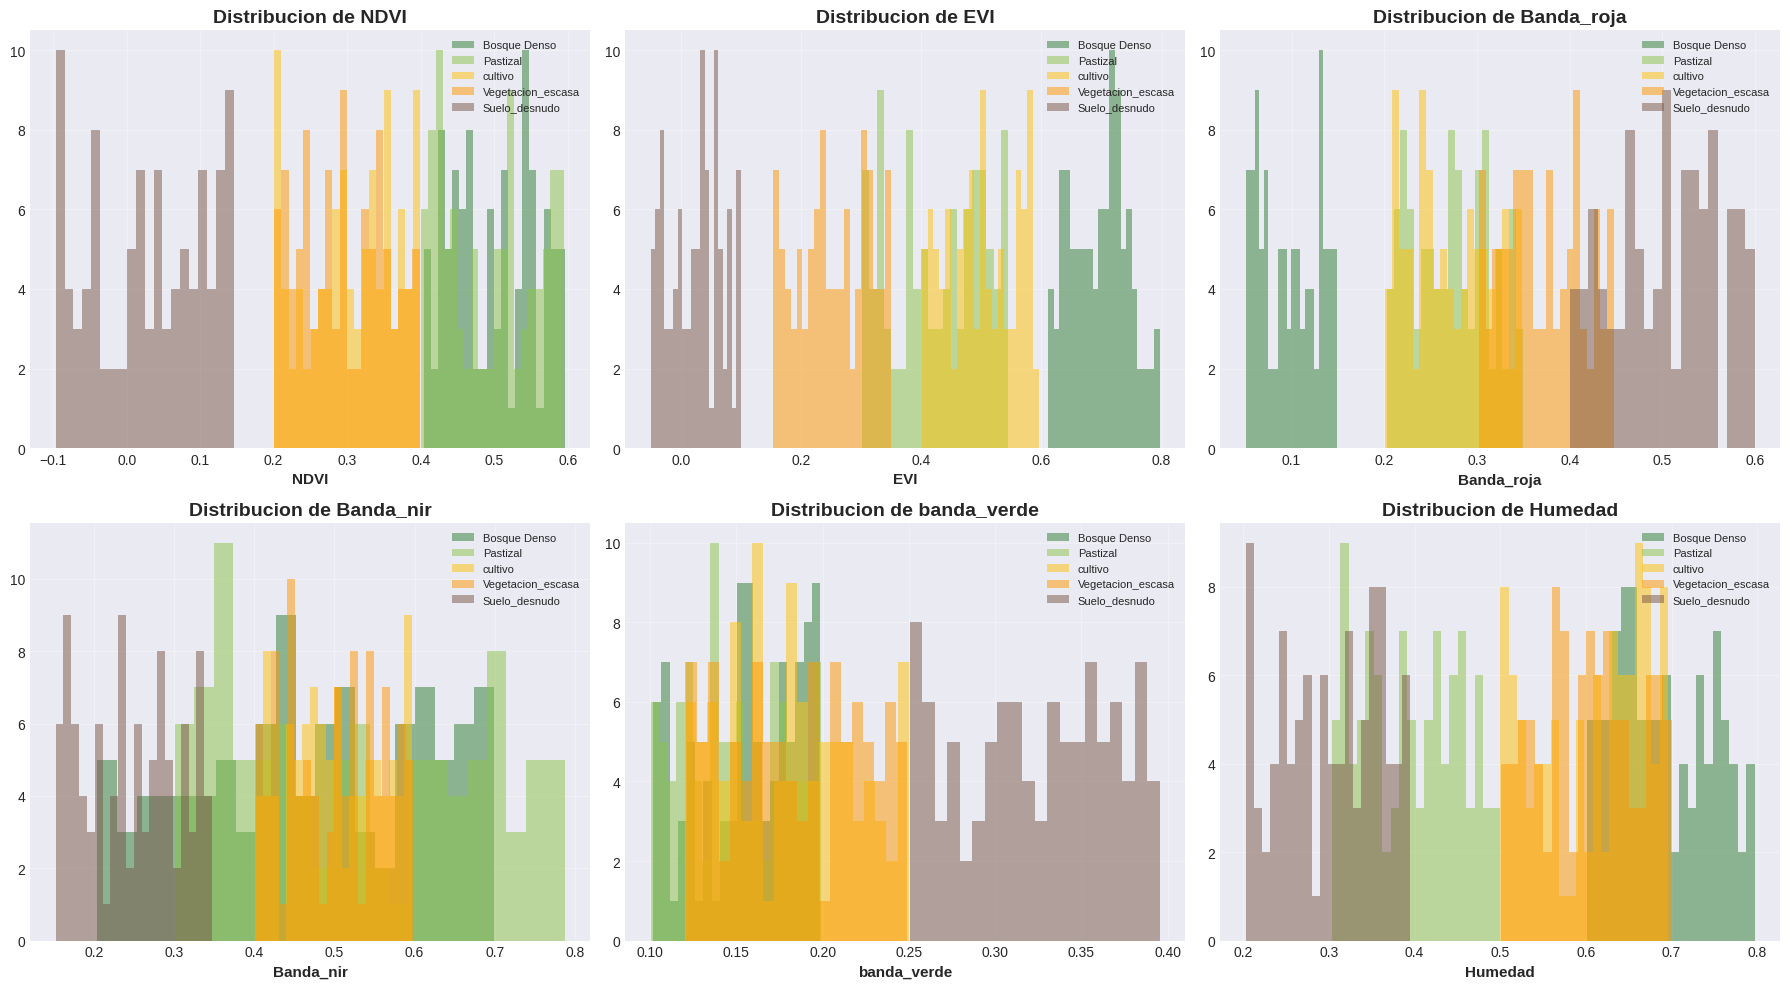


 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES

 Matriz de correlación:
              NDVI    EVI  Banda_roja  Banda_nir  banda_verde  Humedad
NDVI         1.000  0.795      -0.796      0.557       -0.772    0.466
EVI          0.795  1.000      -0.916      0.488       -0.697    0.682
Banda_roja  -0.796 -0.916       1.000     -0.426        0.667   -0.649
Banda_nir    0.557  0.488      -0.426      1.000       -0.590    0.406
banda_verde -0.772 -0.697       0.667     -0.590        1.000   -0.545
Humedad      0.466  0.682      -0.649      0.406       -0.545    1.000


In [13]:
variables = [ 'NDVI',  'EVI', 'Banda_roja', 'Banda_nir', 'banda_verde', 'Humedad']
colores = {'Bosque Denso': '#2F7D32', 'Pastizal': '#8BC34A',
                   'cultivo': '#FFC107', 'Vegetacion_escasa' : '#FF9800',
                   'Suelo_desnudo': '#795548'}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10)) # Create figure and subplots
#axes = axes.flatten() # Flatten the 2x3 array of axes for easy iteration

for idx, var in enumerate(variables):
  ax = axes[idx // 3, idx % 3] # Get the current subplot axis
  for tipo in tipo_vegetacion.keys():
    datos_tipo = df[df['Tipo_Real'] == tipo][var]
    ax.hist(datos_tipo, bins=20, alpha=0.5, label=tipo, color=colores[tipo])

  ax.set_xlabel(var, fontsize=11, fontweight='bold')
  ax.set_title(f'Distribucion de {var}', fontsize=14, fontweight='bold')
  ax.legend(fontsize=8, loc='upper right')
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Matriz de correlación
print("\n ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES")
print("=" * 60)

correlación = df[variables].corr()
print("\n Matriz de correlación:")
print(correlación.round(3))